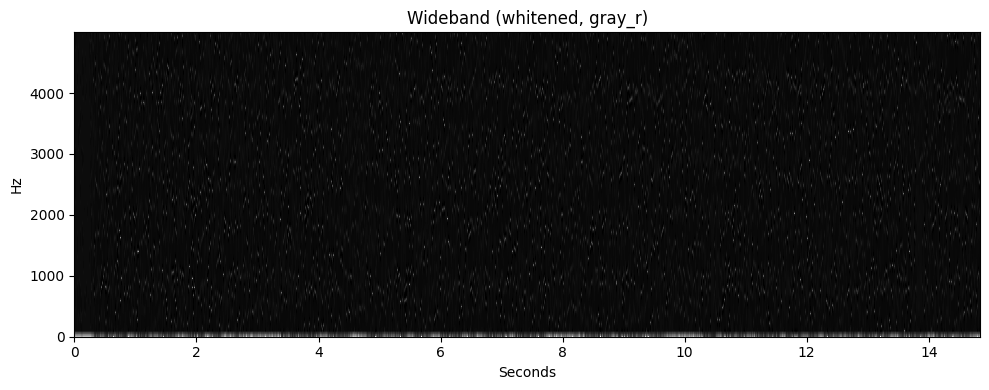

In [14]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def preemphasis_np(x, alpha=0.97):
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - alpha * x[:-1]
    return y

def wideband_readable_spec(
    x, sr,
    win_ms=5.0,
    hop_ms=1.0,
    n_fft=2048,          # <-- bigger FFT is important
    top_db=55.0,
    preemph=0.97,
    whiten_hz=200.0,     # <-- smoothing scale for whitening (try 150–300 Hz)
    fmax=5000
):
    x = preemphasis_np(x, preemph)

    win_length = int(sr * win_ms / 1000.0)
    hop_length = int(sr * hop_ms / 1000.0)

    S = np.abs(librosa.stft(
        x,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hann",
        center=True
    ))**2

    S_db = librosa.power_to_db(S, ref=np.max)

    # --- Per-frame whitening (remove smooth spectral envelope / tilt) ---
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    df = freqs[1] - freqs[0]
    # smoothing kernel width in bins (odd)
    k = int(max(3, round(whiten_hz / df)))
    if k % 2 == 0:
        k += 1
    kernel = np.ones(k, dtype=np.float32) / k

    # smooth along frequency axis for each frame
    smooth = np.apply_along_axis(lambda v: np.convolve(v, kernel, mode="same"), 0, S_db)
    S_db_w = S_db - smooth  # emphasize formant ridges / frication bands

    # --- Now do Praat-like dynamic-range clipping on the whitened image ---
    vmax = np.percentile(S_db_w, 99.5)   # robust ceiling; avoids one loud frame ruining contrast
    vmin = vmax - top_db
    S_db_w = np.clip(S_db_w, vmin, vmax)

    # limit freq range for plotting
    keep = freqs <= fmax
    S_db_w = S_db_w[keep]
    freqs = freqs[keep]

    times = librosa.frames_to_time(np.arange(S_db_w.shape[1]), sr=sr, hop_length=hop_length)
    return S_db_w, freqs, times, vmin, vmax

def plot_spec(S_db, freqs, times, vmin, vmax, title=""):
    plt.figure(figsize=(10, 4))
    plt.imshow(
        S_db,
        origin="lower",
        aspect="auto",
        interpolation="none",
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap="gray_r",
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("Seconds")
    plt.ylabel("Hz")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Speech sample
x, sr = librosa.load(librosa.ex("libri1"), sr=None, mono=True)

S_db, freqs, times, vmin, vmax = wideband_readable_spec(
    x, sr,
    win_ms=5.0,
    hop_ms=1.0,
    n_fft=2048,      # try 4096 too if sr is high
    top_db=55.0,
    whiten_hz=200.0,
    fmax=5000
)

plot_spec(S_db, freqs, times, vmin, vmax, title="Wideband (whitened, gray_r)")
